In [1]:
%matplotlib inline
import numpy as np
from numpy import linalg as la
import matplotlib.pylab as plt
from scipy.optimize import fsolve
import math
import statsmodels.api as sm
from scipy.stats import norm
import seaborn as sns
from scipy import stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [2]:
import scipy
from functools import partial
def odeIntegral(x,t,J,I=0):
    x = np.squeeze(x)
    x = np.reshape(x,(len(x),1))
    # dxdt = -x+J@np.tanh(x)#+I[0]
    dxdt = -x+J@x+I[0]
    return np.squeeze(dxdt)
def odesimulation(t,xinit,Jpt,I):
	return scipy.integrate.odeint(partial(odeIntegral,J=Jpt,I=I),xinit,t)
shiftx = 1.5
def odeIntegralP(x,t,J,I=0):
	x = np.squeeze(x)
	x = np.reshape(x,(len(x),1))
	# print('size:',np.shape(x),np.shape(J@np.tanh(x)))
	dxdt = -x+J@(1.0+np.tanh(x-shiftx))
	return np.squeeze(dxdt)
def odesimulationP(t,xinit,Jpt,I):
	return scipy.integrate.odeint(partial(odeIntegralP,J=Jpt,I=I),xinit,t)

In [3]:
### define the network parameters of the adjacency matrix
N  = 1500
Kt = int(N*0.2)
J = 1/np.sqrt(N)*0.5  ### TODO: make sure this scalar with David&Stefano's paper
# J = 0.00325
ntau   = 10#21#
trials = 30+6
tau_series = np.linspace(0,0.225,ntau)# np.linspace(0.25,0.4,ntau)#

switch = 1
htau = tau_series[1]-tau_series[0]
### simulation using the low-rank framework
firing_rateeq = np.zeros((trials,ntau,N))
g, gamma =  6, 1/4.0
NE = int(N/(1+gamma))
NI = N-NE#NE*gamma
N  = NE+NI ### update 
ALPHAE, ALPHAI = NE/N, NI/N
KE, KI = int(Kt/(1+gamma)), int(Kt/(1+gamma)*gamma) ### fixed out-degree
ce, ci = KE/NE, KI/NI
print('ce and ci:',ce,ci)
### assert that the differences between ce and ci are smaller than epsilon
epsilon = 1E-2
assert np.abs(ce-ci)<epsilon
# assert ce==ci
c = ce
ji,je = g*J,J 
### define the network parameters of the diluted Gaussian matrix 
ge, gi = np.sqrt(je**2*c*(1-c)*N), np.sqrt(ji**2*c*(1-c)*N) 
hat_sigmae, hat_sigmai = np.sqrt(c*(1-c)), np.sqrt(c*(1-c))### standard deviation of the adjacency matrix
sigmae,sigmai = np.sqrt(c*(1-c)*J**2*N), np.sqrt(c*(1-c)*(-g*J)**2*N)### with magnitude of the coupling
JE,JI = je*c*NE, ji*c*NI 
lambda0 = JE-JI 

ce and ci: 0.2 0.2


In [4]:
'''parameters used in SONETs'''
alpha_series = (tau_series*c*(1-c)+c**2)/c**2-1
alpha_series_rec = (tau_series*2*c*(1-c)+c**2)/c**2-1
print('SONETs parameters:',alpha_series)
print('SONETs parameters reciprocal:',alpha_series_rec)
((alpha_series+1)*c**2-c**2)/c/(1-c)

SONETs parameters: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
SONETs parameters reciprocal: [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8]


array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225])

In [5]:
# tau_series = np.array([0.025, 0.05 , 0.075, 0.1  ])
eigvchn_series, eigrvec_series, eiglvec_series = np.zeros((trials,ntau,N),dtype=complex), np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
eiglvec0_series, norml0_series = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau+1,N)) 
### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 
## TEST THE EIGENVALUES OF THE MEAN MATRIX 
eigvJ0, eigvecJ0 = la.eig(Jbar)
print('eigvJ0:',eigvJ0[0],' theory:',JE-JI)
### mean left and right eigenvectors
leigvec0, reigvec0 = np.zeros((N,N)), np.zeros((N,N))
norm_left = np.zeros(2)
## first eigenvector
leigvec0[:,0], reigvec0[:,0] = nvec[:,0]/(JE-JI)/np.sqrt(N), mvec[:,0]/np.sqrt(N)
norm_left[0]  = la.norm(leigvec0[:,0])
leigvec0[:,0] = leigvec0[:,0]/norm_left[0]
norml0_series[:,0,0] = np.sum(leigvec0[:,0]*reigvec0[:,0])
### compute the square of the random connectivity 
Z2E = N*J**2*hat_sigmae**2*tau_series*ALPHAE-N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAI
Z2I = -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAE+N*g**2*J**2*hat_sigmai**2*tau_series*ALPHAI
DeltaZ2E, DeltaZ2I = Z2E[1]-Z2E[0],Z2I[1]-Z2I[0] ### for practical use
print('DeltaZ2E,DeltaZ2I:',DeltaZ2E,DeltaZ2I)
DeltaZ2 = np.zeros((N,N))
DeltaZ2[:,:NE], DeltaZ2[:,NE:] = DeltaZ2E, DeltaZ2I

### E population and I population separately
Z2E_E, Z2I_E = N*J**2*hat_sigmae**2*tau_series*ALPHAE, -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAI
Z2E_I, Z2I_I = -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAE, N*g**2*J**2*hat_sigmai**2*tau_series*ALPHAI
DeltaZ2E_E, DeltaZ2I_E = Z2E_E[1]-Z2E_E[0],Z2I_E[1]-Z2I_E[0] ### for practical use
DeltaZ2E_I, DeltaZ2I_I = Z2E_I[1]-Z2E_I[0],Z2I_I[1]-Z2I_I[0] ### for practical use
DeltaZ2_E, DeltaZ2_I = np.zeros((N,N)),np.zeros((N,N))
DeltaZ2_E[:,:NE], DeltaZ2_E[:,NE:] = DeltaZ2E_E, DeltaZ2I_E

eigvJ0: (-1.5491933384830117+0j)  theory: -1.5491933384829668
DeltaZ2E,DeltaZ2I: -0.0004000000000000003 0.0024000000000000002


#### Construct Sparse Networks using SONETs (adjacency matrix)

In [5]:
alphachn_series  = np.array([0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900])
alpha_series_rec = np.array([0.000,0.200,0.400,0.600,0.800,1.000,1.200,1.400,1.600,1.800])

In [6]:
#### constant and deterministic input signal
Inp   = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
Ipert = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
Ipert[NE:]=0
tt = np.linspace(0,100,1000)
#### random and structural input signal 
### simulation using the mean network connectivity (inhibition-dominated)
Jpt   = Jbar.copy()
xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
xtemporal = odesimulation(tt, xinit, Jpt, Inp)
firing_rate0 = np.reshape(xtemporal[-1,:N],(N,1))

In [7]:
ce=ci=c
### generate i.i.d. sparse network!
def randbin(M,N,P):  
    return np.random.choice([0, 1], size=(M,N), p=[P, 1-P])

sparseiid_dyns = np.zeros((trials,N,1))
for ktrial in range(trials):
    ### generate iid sparse connectivity 
    Ecol = randbin(1,NE*N,1-ce)
    Icol = randbin(1,NI*N,1-ci)
    Ecol = np.reshape(Ecol,(N,NE))
    Icol = np.reshape(Icol,(N,NI))
    iidsparse = np.zeros((N,N))
    iidsparse[:,:NE], iidsparse[:,NE:] = Ecol.copy()*J,Icol.copy()*J*(-g)
    xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
    xtemporal = odesimulation(tt, xinit, iidsparse, Inp)
    firing_rate0 = np.reshape(xtemporal[-1,:N],(N,1))
    sparseiid_dyns[ktrial,:,:] = firing_rate0.copy()
    
sparseiid_dyns = np.squeeze(sparseiid_dyns)
mean_sparseiid_dyns = np.zeros((trials,2))
for ktrial in range(trials):
    mean_sparseiid_dyns[ktrial,0],mean_sparseiid_dyns[ktrial,1]= np.mean(sparseiid_dyns[ktrial,:NE]),np.mean(sparseiid_dyns[ktrial,NE:])
trialavg_sparseiid_dyns = np.mean(mean_sparseiid_dyns,axis=0)
trialstd_sparseiid_dyns = np.std(mean_sparseiid_dyns,axis=0)
print(trialavg_sparseiid_dyns)

[0.01026444 0.01017392]


In [ ]:
''' test.sh code '''
# for seed in {0..36}; do
# ./run_secorder 1500 0.2 0.0 0.0 0.0 0 $seed
# ./run_secorder 1500 0.2 0.2 0.1 0.1 1 $seed
# ./run_secorder 1500 0.2 0.4 0.2 0.2 1 $seed
# ./run_secorder 1500 0.2 0.6 0.3 0.3 1 $seed
# ./run_secorder 1500 0.2 0.8 0.4 0.4 1 $seed
# ./run_secorder 1500 0.2 1.0 0.5 0.5 1 $seed
# ./run_secorder 1500 0.2 1.2 0.6 0.6 1 $seed
# ./run_secorder 1500 0.2 1.4 0.7 0.7 1 $seed
# ./run_secorder 1500 0.2 1.6 0.8 0.8 1 $seed
# ./run_secorder 1500 0.2 1.8 0.9 0.9 1 $seed

# done

# for seed in 1 4 8 10 13 14 18 19 25 26 31 32 34 36 40 43 44 49 52 53 55 60 62 64 71 73 76 78 81 82 83 84 85 86 87 88 93 94 95; do
# ./run_secorder 1500 0.2 0.0 0.0 0.0 0 $seed
# ./run_secorder 1500 0.2 0.2 0.1 0.1 1 $seed
# ./run_secorder 1500 0.2 0.4 0.2 0.2 1 $seed
# ./run_secorder 1500 0.2 0.6 0.3 0.3 1 $seed
# ./run_secorder 1500 0.2 0.8 0.4 0.4 1 $seed
# ./run_secorder 1500 0.2 1.0 0.5 0.5 1 $seed
# ./run_secorder 1500 0.2 1.2 0.6 0.6 1 $seed
# ./run_secorder 1500 0.2 1.4 0.7 0.7 1 $seed
# ./run_secorder 1500 0.2 1.6 0.8 0.8 1 $seed
# ./run_secorder 1500 0.2 1.8 0.9 0.9 1 $seed
# done

# for seed in 1 4 8 10 13 14 18 19 25 26 31 32 34 36 40 43 44 49 52 53 55 60 62 64 71 73 76 78 81 82 83 84 85 86 87 88 93 94 95; do     mkdir -p "seed_$seed"; done

In [ ]:
trials = 36
alphachns     = ['0.000','0.100','0.200','0.300','0.400','0.500','0.600','0.700','0.800','0.900']
alphachns_rec = ['0.000','0.200','0.400','0.600','0.800','1.000','1.200','1.400','1.600','1.800']
# alphachns_arr = np.array([0.1,0.2,0.3,0.4])
Inp   = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
firing_ratepert = np.zeros((trials,ntau,N))
eigvchn_series = np.zeros((trials,len(alphachns),N),dtype=complex)
eiglvec0norm_series= np.zeros((trials,ntau,N,2))
leig0mean_series = np.zeros((trials,ntau,N,2))
leig0pre_series = np.zeros((trials,ntau,N,2))
norm_4rvec_series, norm_4lvec_series = np.zeros((trials,ntau,2)),np.zeros((trials,ntau,2))
norm_4lvec_series_ = np.zeros((trials,ntau,2))

intg_mean_series  = np.zeros((trials,ntau,N,2,3))### mean overlap matrix rank and 
# tauchns_arr = alphachns_arr*c**2/c/(1-c)
seedss = np.array([1, 4, 8, 10, 13, 14, 18, 19, 25, 26, 31, 32, 34, 36, 40, 43, 44, 49, 52, 53, 55 ,60, 62, 64, 71, 73, 76, 78, 81, 82, 83,84, 85, 86, 87, 88, 93, 94, 95])
for ktrial in range(trials):
    seed =seedss[ktrial]
    z_pre = 0
    for idxalpha, alphachn in enumerate(alphachns[:]):
        # if idxalpha <8:
        #     continue
        if idxalpha == 0:       
            file_path = 'K:\\Projects\\Allen_motif\\PRXL_data\\sonets\\N1500\\seed_'+str(seed)+'\\w_1500_0.200_'+alphachns_rec[idxalpha]+'_'+alphachn+'_'+alphachn+'_0.000_'+str(seed)+'.dat'
        else:
            file_path = 'K:\\Projects\\Allen_motif\\PRXL_data\\sonets\\N1500\\seed_'+str(seed)+'\\w_1500_0.200_'+alphachns_rec[idxalpha]+'_'+alphachn+'_'+alphachn+'_1.000_'+str(seed)+'.dat'
        Jmat = np.zeros((N,N))
        count =0
        with open(file_path, 'r') as file:
            content = file.read()
            if content == '0':
                print('File is empty') 
            else:
                for line in content.split('\n'):
                    if line:
                        Jmat[count,:]=([(x) for x in line.split()])
                        count +=1       
        Jmat[:,:NE] = Jmat[:,:NE]*je
        Jmat[:,NE:] = Jmat[:,NE:]*(-ji)

        ktrial, it = ktrial, idxalpha
        ### full rank simulation
        xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
        xc_temporal = odesimulation(tt, xinit, Jmat, Inp)
        firing_rateeq[ktrial,it,:] = xc_temporal[-1,:].copy()
        
        ### perturbation 
        xpert = xc_temporal[-1,:].copy()
        xpert = xpert.reshape(-1,1)
        dtt =tt[1]-tt[0]
        for ttt in range(len(tt)):
            delta_x= -xpert + Jmat@xpert.reshape(-1,1)+Ipert.reshape(-1,1)+Inp.reshape(-1,1)
            xpert = delta_x*dtt+xpert 
        firing_ratepert[ktrial,it,:] = xpert.copy().squeeze()
            
        zr = Jmat - Jbar
        ### compute the eigenvalues and eigenvectors of the matrix
        eigvchn, eigrvec = la.eig(Jmat)
        ## sort the eigenValues by it's norm of the real part 
        idxeigv = np.argsort(np.abs(eigvchn))
        idxeigv = idxeigv[::-1]
        eigvchn, eigrvec = eigvchn[idxeigv],eigrvec[:,idxeigv]
        
        eigvchn_,eiglvec = la.eig(Jmat.copy().T)
        idxeigv = np.argsort(np.abs(eigvchn_))
        idxeigv = idxeigv[::-1]
        eigvchn_, eiglvec = eigvchn[idxeigv],eiglvec[:,idxeigv]
        
        ### normalization
        reig    = np.squeeze(eigrvec[:,:].copy())
        leig0   = np.squeeze(eiglvec[:,:].copy()) 
        normval = np.sum(reig.copy()*leig0.copy(),axis=0)
        
        norml0_series[ktrial,it+1,:] = normval.copy() ### normalization factor shift right 1byte
        normval = np.repeat(np.reshape(normval,(1,N)),N,axis=0)
        leig = leig0.copy()/normval.copy()### left eigenvector normalization to make <l|r>=1
        if np.mean(reig[:NE,0])<0:
            reig[:,0]*=-1
            leig[:,0]*=-1
            leig0[:,0]*=-1
        if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
            reig[:,1]*=-1
            leig[:,1]*=-1
            leig0[:,1]*=-1
                    
              
        print('seed:',seed,'alphachn:',alphachn,'idxalpha:',idxalpha)
        print('eigenvalues',eigvchn[:2])
        
        DELTA_Z = np.zeros((N,N))
        DELTA_Z = zr-z_pre  
        hzr = DELTA_Z.copy()
        
        eigvchn_series[ktrial,it,:] = eigvchn[:] 
        eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
        eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
        eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#
        for iii in range(2):
            eiglvec0norm_series[ktrial,it,:,iii] = leig0[:,iii].copy()/normval[iii,iii]
    
        
        z_pre = zr.copy()    

In [8]:
data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/ConnStats_WD_Adjacency_4April_PRX_60N1500_normlr_paradoxical.npz"
# data_name = "/Users/shaoyuxiu/Library/CloudStorage/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/ConnStats_WD_Adjacency_4April_PRX_60N1500_normlr_paradoxical.npz"
# np.savez(data_name, **data)
### load data  
data = np.load(data_name,allow_pickle=True)
eigvchn_series = data['eigvchn_series']
eigrvec_series = data['eigrvec_series']
eiglvec_series = data['eiglvec_series']
eiglvec0_series = data['eiglvec0_series']
norml0_series = data['norml0_series']
params = data['params']
intg_mean_series = data['intg_mean_series']
firing_rateeq = data['firing_rateeq']
firing_ratepert = data['firing_ratepert']

In [24]:
# params = {'g':g,
#           'gamma':gamma,
#           'NE':NE,
#           'NI':NI,
#           'c':c,
#           'J':J,
#           'tau_series':tau_series,
#           }
# lst = [eigvchn_series, eigrvec_series, eiglvec_series,
#        eigrvec_series_rec, eiglvec_series_rec,
#         eiglvec0_series, norml0_series, params,
#         lowrank_eq, firing_rateeq,lowrank_eq_num,
#         ovs_inplr, ovs_inplr_num,ovs_inplr_div, ovs_inplr_div_num,
#         contributions_lr, contributions_lr_num,
#         intg_mean_series,leig0mean_series,
#         norm_4lvec_series,norm_4rvec_series,norm_4lvec_series_]
# stg = ["eigvchn_series, eigrvec_series, eiglvec_series,"
#        "eigrvec_series_rec, eiglvec_series_rec,"
#         "eiglvec0_series, norml0_series, params,"
#         "lowrank_eq, firing_rateeq,lowrank_eq_num,"
#         "ovs_inplr, ovs_inplr_num,ovs_inplr_div, ovs_inplr_div_num,"
#         "contributions_lr, contributions_lr_num,"
#         "intg_mean_series,leig0mean_series,"
#         "norm_4lvec_series,norm_4rvec_series,norm_4lvec_series_"]
# data = list_to_dict(lst=lst, string=stg)
data_name ="E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/Numerics_remote/ConnStats_WD_Adjacency_PRX_60N1500_nonISN_exc_paradoxical.npz" ## Fig D4
# np.savez(data_name, **data)
### load the stored data, in particular, extracting variable: eigvchn_series 
# data = np.load(data_name,allow_pickle=True)

# ### also loading other variables 
# eigvchn_series = data['eigvchn_series']
# eigrvec_series = data['eigrvec_series']
# eiglvec_series = data['eiglvec_series']
# eigrvec_series_rec = data['eigrvec_series_rec']
# eiglvec_series_rec = data['eiglvec_series_rec']
# eiglvec0_series = data['eiglvec0_series']
# norml0_series = data['norml0_series']
# params = data['params']
# intg_mean_series = data['intg_mean_series']
# leig0mean_series = data['leig0mean_series']



In [9]:
ce, ci = c,c
radius_theo_map = np.zeros(ntau)
for it, tau in enumerate(tau_series):
    ### mean connectivity 
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    # tau_rec_vec = np.array([[0,0],[0,0]])
    tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,tau],[tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma
    
    radius_theo_map[it] = radius_theo
            
### theoretical prediction of the eigenvalues

org_k = J*N*(ALPHAE-g*ALPHAI)/2.0
eigvchn_theo = np.zeros((ntau,2))
eigvchn_theo[:,0] = org_k*(c+np.sqrt(c**2+4*c*(1-c)*tau_series))
eigvchn_theo[:,1] = org_k*(c-np.sqrt(c**2+4*c*(1-c)*tau_series))

In [10]:
### compute the numerical radius
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn = eigvchn_series[ktrial,it,:].copy()

        eigvchn_real = np.real(eigvchn)
        eigvchn_real = np.sort(eigvchn_real)
        eigvchn_real = eigvchn_real[::-1]

        radius = (eigvchn_real[2])
        radius_num_map[ktrial,it] = radius

In [11]:
#### print trial by trial the first two eigenvallues
for ktrial in range(trials):
    eigvchn = eigvchn_series[ktrial,:,:].copy()
    eigvchn_real = (eigvchn)
# ### delete the 17th trial
# eigvchn_series = np.delete(eigvchn_series,17,axis=0) #for ConnStats_Adjacency_12OctDense_.npz
### sorting the 3 maximum eigvchn_series[:,-1,0].real and 3 minimum
eigvchn_real = eigvchn_series[:,-1,0].real.copy()
### sorting eigvchn_real 
idx = np.argsort(eigvchn_real)
idx_eff = idx[3:-3]
print('effective trials:',idx_eff,len(idx_eff))

effective trials: [ 8 20 21 29 24  9 15 17  4  0 30 35  3 31 14  5 13 25 28 18 10 33 34 12
 26 16  1 23  7 22] 30


In [12]:
### 
plt.close('all')
meanfr_eq = np.zeros((trials,ntau,2))
meanfr_pert = np.zeros((trials,ntau,2))
meanfr_eq[:,:,0] = np.mean(firing_rateeq[:,:,:NE],axis=2)
meanfr_eq[:,:,1] = np.mean(firing_rateeq[:,:,NE:],axis=2)
### same for pydll Creates ()
meanfr_pert[:,:,0] = np.mean(firing_ratepert[:,:,:NE],axis=2)
meanfr_pert[:,:,1] = np.mean(firing_ratepert[:,:,NE:],axis=2)

In [13]:
### numerical
mean_reigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leig0vec_num_series = np.zeros((trials,ntau,2,2))

thl = 1.5
ths = 1.5
                
### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        if it<2:
            threshold = ths
        else:
            threshold = thl
        for ir in range(2):
            mean_reigvec_num_series[ktrial,it,ir,0] = np.mean(eigrvec_series[ktrial,it,:NE,ir])
            mean_reigvec_num_series[ktrial,it,ir,1] = np.mean(eigrvec_series[ktrial,it,NE:,ir])
            mean_leigvec_num_series[ktrial,it,ir,0] = np.mean(eiglvec_series[ktrial,it,:NE,ir])
            mean_leigvec_num_series[ktrial,it,ir,1] = np.mean(eiglvec_series[ktrial,it,NE:,ir])
            
### select the middle 30 values 
kktrial = np.arange(trials)
cuts = 6#3
for it in range(ntau):
    for ir in range(2):
       
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        


In [14]:
mean_rvec = np.zeros((ntau,2,2))
mean_lvec = np.zeros((ntau,2,2))

for it in range(ntau):
    for ir in range(2):
        for ip in range(2):
            mean_rvec[it,ir,ip] = np.nanmean(mean_reigvec_num_series[:,it,ir,ip])
            mean_lvec[it,ir,ip] = np.nanmean(mean_leigvec_num_series[:,it,ir,ip])*eigvchn_theo[it,ir].real
            
### compute the theoretical response function 
response_func = np.zeros((trials,ntau,2))

### compute the theoretical response function 
rank = 2
response_func_contribution = np.zeros((ntau,rank,2))

for it in range(ntau):
    response_func[:,it,0] = 1
    if it>4:#it>-1:#it>4: ## i<5 in main code 
        for ir in range(2):
            response_func[:,it,0] += (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,0] = (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            
            print('it...:',it,ir,response_func_contribution[it,ir,0],response_func_contribution[it,ir,1])
    else:
        for ir in range(1):
            response_func[:,it,0] += (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            
            response_func_contribution[it,ir,0] = (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)


it...: 5 0 1.0706527771337264 1.0726299337979621
it...: 5 1 -0.04091969258949958 -0.04033983123328395
it...: 6 0 1.0297862627788963 1.0338632139411201
it...: 6 1 -0.3568912417898164 -0.32416310161091455
it...: 7 0 0.9962475658622623 0.9977977596000693
it...: 7 1 -0.6870825445130126 -0.6431163030244121
it...: 8 0 0.9800080940107512 0.9808237328294777
it...: 8 1 -2.020041320493815 -1.8935832838832163
it...: 9 0 0.9838717148071868 0.9819840197563002
it...: 9 1 -3.558023594464012 -3.3920449525620895


In [15]:
### 
meanfr_eq = np.zeros((trials,ntau,2))
meanfr_pert = np.zeros((trials,ntau,2))
meanfr_eq[:,:,0] = np.mean(firing_rateeq[:,:,:NE],axis=2)
meanfr_eq[:,:,1] = np.mean(firing_rateeq[:,:,NE:],axis=2)
### same for pydll Creates ()
meanfr_pert[:,:,0] = np.mean(firing_ratepert[:,:,:NE],axis=2)
meanfr_pert[:,:,1] = np.mean(firing_ratepert[:,:,NE:],axis=2)
### numerical response function 
response_func_num = np.zeros((trials,ntau,2))
for ktrial in range(trials):
    for it in range(ntau):
        response_func_num[ktrial,it,0]=(meanfr_pert[ktrial,it,0]-meanfr_eq[ktrial,it,0])/Ipert[0]
        response_func_num[ktrial,it,1]=(meanfr_pert[ktrial,it,1]-meanfr_eq[ktrial,it,1])/Ipert[0]
        
#### delete the largest 3 and the smallest 3 from response_func_num
for it in range(ntau):
    idxsort = np.where(np.abs(response_func_num[:,it,0].copy())>1e2)#1e2)
    idxnan = (idxsort) 
    response_func_num[idxnan,it,0] = np.nan 
    
    
    idxsort = np.where(np.abs(response_func_num[:,it,1].copy())>1e2)#1e2)
    idxnan = (idxsort) 
    response_func_num[idxnan,it,1] = np.nan 

Fig D4 (a)

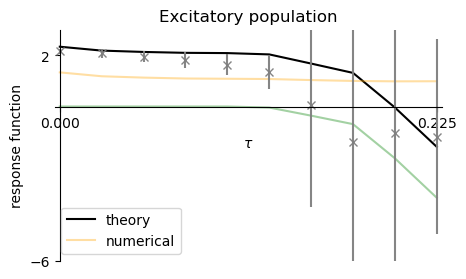

In [16]:
### compare response_func with response_func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:trials,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:trials,:,:],axis=0)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tau_series,response_func_mean[:,0],'k',)
ax.plot(tau_series,response_func_contribution[:,0,0],'orange',alpha=0.36)
ax.plot(tau_series,response_func_contribution[:,1,0],'green',alpha=0.36)
# ### numerical using filled_between 
# ax.fill_between(tau_series,response_func_num_mean[:,0]+np.nanstd(response_func_num[:,:,:],axis=0)[:,0],response_func_num_mean[:,0]-np.nanstd(response_func_num[:,:,:],axis=0)[:,0],color='k',alpha=0.3)
alphass = 0.95
ax.errorbar(tau_series[:],response_func_num_mean[:,0],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,0],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('response function')
ax.set_title('Excitatory population')
ax.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',0))
## set yaxis, ylim not too large!
ax.set_ylim([-6,3])
ax.set_xlim([0-dtau/8,tau_series[-1]+dtau/8])
ax.set_yticks([-6,2])
ax.set_xticks([0,tau_series[-1]])
plt.show()

Fig D4(b)

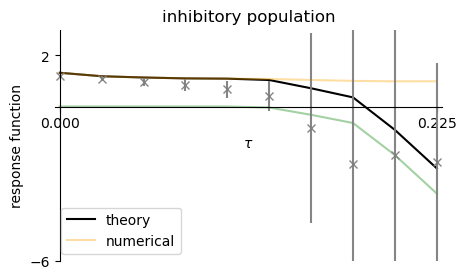

In [17]:

### compare response_func with response_func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tau_series,response_func_mean[:,1],'k')
ax.plot(tau_series,response_func_contribution[:,0,1],'orange',alpha=0.36)
ax.plot(tau_series,response_func_contribution[:,1,1],'green',alpha=0.36)
alphass = 0.95
ax.errorbar(tau_series[:],response_func_num_mean[:,1],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,1],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)

# ax.fill_between(tau_series,response_func_num_mean[:,1]+np.std(response_func_num[:,:,:],axis=0)[:,1],response_func_num_mean[:,1]-np.std(response_func_num[:,:,:],axis=0)[:,1],color='black',alpha=0.3)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('response function')
ax.set_title('inhibitory population')
ax.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',0))
## set yaxis, ylim not too large!
ax.set_ylim([-6,3])
ax.set_xlim([0-dtau/8,tau_series[-1]+dtau/8])
ax.set_yticks([-6,2])
ax.set_xticks([0,tau_series[-1]])
plt.show()

In [114]:
def list_to_dict(lst, string):
    """
    Transform a list of variables into a dictionary.
    Parameters
    ----------
    lst : list
        list with all variables.
    string : str
        string containing the names, separated by commas.
    Returns
    -------
    d : dict
        dictionary with items in which the keys and the values are specified
        in string and lst values respectively.
    """
    string = string[0]
    string = string.replace(']', '')
    string = string.replace('[', '')
    string = string.replace('\\', '')
    string = string.replace(' ', '')
    string = string.replace('\t', '')
    string = string.replace('\n', '')
    string = string.split(',')
    d = {s: v for s, v in zip(string, lst)}
    return d